# Evaluation: synthetic data experiments

Here we process the results of the synthetic data experiments following Ishida et al. (2020), also using [some handy coding examples](https://gist.github.com/DavidWalz/0f5e84ffc4c3929f3af5a93268eaeab9).

In [1]:
# External modules.
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import os

# Internal modules.
from setup.directories import img_path
from setup.results import my_ext
from setup.utils import makedir_safe

In [2]:
# Make a directory to store images, if one doesn't exist already.
makedir_safe(img_path)

In [3]:
# Specify an experiment name, get relevant information.
exp_name = "exp:gaussian"
data_name = exp_name.split(":")[1]
experiment = mlflow.get_experiment_by_name(name=exp_name)
print("Experiment_id: {}".format(experiment.experiment_id))
#print("Artifact Location: {}".format(experiment.artifact_location))
print("Tags: {}".format(experiment.tags))
print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))
print("Creation timestamp: {}".format(experiment.creation_time))
exp_id = experiment.experiment_id

Experiment_id: 501973923526054736
Tags: {}
Lifecycle_stage: active
Creation timestamp: 1696904097577


As we will see below, the object returned by `mlflow.search_runs(exp_id)` is an instance of a `DataFrame` within the "pandas" library. The `DataFrame` is just a simple class for managing "tabular" data, i.e., data organized into rows and columns. A two-dimensional array. Let's take a look at the points characterizing this particular data frame.

In [4]:
# Take a look at the "runs" associated with the selected experiment.
runs = mlflow.search_runs(exp_id)
runs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3632 entries, 0 to 3631
Data columns (total 50 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   run_id                          3632 non-null   object             
 1   experiment_id                   3632 non-null   object             
 2   status                          3632 non-null   object             
 3   artifact_uri                    3632 non-null   object             
 4   start_time                      3632 non-null   datetime64[ns, UTC]
 5   end_time                        3632 non-null   datetime64[ns, UTC]
 6   metrics.acc_tr                  3630 non-null   float64            
 7   metrics.loss_tr                 3630 non-null   float64            
 8   metrics.acc_te                  3630 non-null   float64            
 9   metrics.model_norm              3630 non-null   float64            
 10  metrics.loss

Okay, so we have 49 columns, each with one or more "entries" that we can interpret as rows. Each "entry" is associated with a single "run" (in mlflow terms). It should also be noted that the "Non-Null Count" (i.e., the number of non-null entries) differs between columns. Here, the null entries are associated with the "parent runs" (one for each noise level). There are no entries for these runs because no metrics are assigned to the parent runs, only their children.

Anyways, moving forward, we want to extract runs as follows.

- First, take runs from a particular *noise level*.
- Next, for each *trial* and each *method*, using validation data to choose the best method setting (assuming there are multiple settings).
- Finally, we want to compute statistics for the selected methods (ave, stdev, etc.) taken over all trials.

Let's set up a script to do this, making sure to do a few relevant sanity checks along the way.

In [5]:
# First, before culling any null values, let's see what label noise values we have.
unique_noise_levels = runs["params.label_noise"].unique()
print("Unique noise levels:", unique_noise_levels)

# Look at all runs with a non-null setting.
runs_notnull = runs[runs["params.label_noise"].notnull()]
notnull_noise_levels = np.sort(runs_notnull["params.label_noise"].unique())
runs_notnull.info()

Unique noise levels: ['0.05' None '0.0']
<class 'pandas.core.frame.DataFrame'>
Index: 3630 entries, 0 to 3630
Data columns (total 50 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   run_id                          3630 non-null   object             
 1   experiment_id                   3630 non-null   object             
 2   status                          3630 non-null   object             
 3   artifact_uri                    3630 non-null   object             
 4   start_time                      3630 non-null   datetime64[ns, UTC]
 5   end_time                        3630 non-null   datetime64[ns, UTC]
 6   metrics.acc_tr                  3630 non-null   float64            
 7   metrics.loss_tr                 3630 non-null   float64            
 8   metrics.acc_te                  3630 non-null   float64            
 9   metrics.model_norm              3630 non-null   f

Excellent. Note that having removed the rows/runs with null values for `params.label_noise`, all the other columns are also now null-free, as expected. That was easy.

Moving forward, we would like to parse the `tags.mlflow.runName` column, splitting it into several columns that makes it much easier to index things.

In [6]:
# First, let's make a copy of the whole data frame to be safe.
runs_notnull_parsed = runs_notnull.copy()

# Next, grab the column to be parsed, populate some lists, turn into Series objects.
mth_family_names = []
mth_numbers = []
trial_numbers = []
for run_name in runs_notnull_parsed["tags.mlflow.runName"]:
    pc_check, mth_details = run_name.split(":")
    if pc_check == "parent":
        raise ValueError("Something is wrong; should not have any parent runs here.")
    elif pc_check == "child":
        mth_family_name, mth_number, trial_info = mth_details.split("-")
        mth_family_names += [mth_family_name]
        mth_numbers += [int(mth_number)]
        trial_numbers += [int(trial_info[1:])]
    else:
        raise ValueError("Something is wrong; did not find a child run.")

# Try adding these columns to the right-most side of the DataFrame of interest.
original_width = runs_notnull_parsed.shape[1]
runs_notnull_parsed.insert(original_width, "trial_number", trial_numbers)
runs_notnull_parsed.insert(original_width, "mth_number", mth_numbers)
runs_notnull_parsed.insert(original_width, "mth_family", mth_family_names)
runs_notnull_parsed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3630 entries, 0 to 3630
Data columns (total 53 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   run_id                          3630 non-null   object             
 1   experiment_id                   3630 non-null   object             
 2   status                          3630 non-null   object             
 3   artifact_uri                    3630 non-null   object             
 4   start_time                      3630 non-null   datetime64[ns, UTC]
 5   end_time                        3630 non-null   datetime64[ns, UTC]
 6   metrics.acc_tr                  3630 non-null   float64            
 7   metrics.loss_tr                 3630 non-null   float64            
 8   metrics.acc_te                  3630 non-null   float64            
 9   metrics.model_norm              3630 non-null   float64            
 10  metrics.loss_te  

Good, that was extremely easy. Before getting into some proper analysis, let's do some basic sanity checks.

In [7]:
# Check family names over noise levels.
for noise_level in notnull_noise_levels:
    print("- Noise level:", noise_level)
    idx = runs_notnull_parsed["params.label_noise"] == noise_level
    runs_tocheck = runs_notnull_parsed[idx]
    unique_trial_numbers = np.sort(runs_notnull_parsed["trial_number"].unique())
    print("- - Unique trial numbers:", unique_trial_numbers)
    unique_family_names = np.sort(runs_notnull_parsed["mth_family"].unique())
    print("- - Unique family names:", unique_family_names)
    # Check method numbers.
    for mth_family_name in unique_family_names:
        idx_methods = runs_tocheck["mth_family"] == mth_family_name
        runs_tocheck_methods = runs_tocheck[idx_methods]
        print("- - - Method number counts ({}):".format(mth_family_name))
        print(runs_tocheck_methods["mth_number"].value_counts())

- Noise level: 0.0
- - Unique trial numbers: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
- - Unique family names: ['ERM' 'Ishida' 'SAM' 'SoftAD']
- - - Method number counts (ERM):
mth_number
0    15
Name: count, dtype: int64
- - - Method number counts (Ishida):
mth_number
39    15
38    15
17    15
16    15
15    15
14    15
13    15
12    15
11    15
10    15
9     15
8     15
7     15
6     15
5     15
4     15
3     15
2     15
1     15
18    15
19    15
20    15
30    15
37    15
36    15
35    15
34    15
33    15
32    15
31    15
29    15
21    15
28    15
27    15
26    15
25    15
24    15
23    15
22    15
0     15
Name: count, dtype: int64
- - - Method number counts (SAM):
mth_number
39    15
38    15
17    15
16    15
15    15
14    15
13    15
12    15
11    15
10    15
9     15
8     15
7     15
6     15
5     15
4     15
3     15
2     15
1     15
18    15
19    15
20    15
30    15
37    15
36    15
35    15
34    15
33    15
32    15
31    15
29    15
21    15
28   

Excellent, the sanity checks come out with the results that we expect. We are going to have need for metrics soon, so let's be sure to grab the metric names now.

In [8]:
# Metric names.
metrics = [c[8:] for c in runs_notnull_parsed.columns if c.startswith("metrics")]

# Specify the metric to be used for validation.
metric_for_validation = "acc_va" #"loss_va" #"acc_va"
if metric_for_validation not in metrics:
    raise ValueError("The selected metric {} is not available...".format(metric_for_validation))
print("All metric names:", metrics)
if metric_for_validation == "loss_va":
    do_argmax = False
elif metric_for_validation == "acc_va":
    do_argmax = True
else:
    raise ValueError("Unexpected metric for validation.")

# Function in charge of selecting the best candidate.
def get_best_idx(metric_history_list, do_argmax=do_argmax):
    '''
    Given a list of sequences, this function returns the index
    of the "best" sequence by taking an *argmax/min* over the *final* values
    of these sequences (e.g., final accuracy, loss, etc.).
    '''
    list_len = len(metric_history_list)
    if list_len < 1:
        raise ValueError("No metric histories provided.")
    elif list_len == 1:
        return 0
    else:
        values_to_compare = []
        for mh in metric_history_list:
            values_to_compare += [mh[-1]] # use last step.
        if do_argmax:
            return np.argmax(np.array(values_to_compare)).item()
        else:
            return np.argmin(np.array(values_to_compare)).item()


All metric names: ['acc_tr', 'loss_tr', 'acc_te', 'model_norm', 'loss_te', 'loss_va', 'acc_va']


To proceed, we set up a loop very similar to the one we just did for our sanity checks, but this time we grab *candidate run IDs*, use these to read in the *metric history*, and then finally choose a *representative run ID* for each combination of (noise level, trial, method family).

In [9]:
# Set up a dictionary where we can store "representative" run IDs and results for each method family.
dict_of_run_ids = {
    nl: {m:[] for m in unique_family_names} for nl in notnull_noise_levels
}
#dict_of_rep_results = {
#    nl: {m:[] for m in unique_family_names} for nl in notnull_noise_levels
#}

# Get the loop going, with a "client" for reading in metric history.
client = mlflow.tracking.MlflowClient()
for noise_level in notnull_noise_levels:
    idx = runs_notnull_parsed["params.label_noise"] == noise_level
    runs_tocheck = runs_notnull_parsed[idx]
    unique_trial_numbers = np.sort(runs_notnull_parsed["trial_number"].unique())
    unique_family_names = np.sort(runs_notnull_parsed["mth_family"].unique())
    for trial_number in unique_trial_numbers:
        runs_tocheck_bytrial = runs_tocheck[runs_tocheck["trial_number"] == trial_number]
        for mth_family_name in unique_family_names:
            idx_candidates = runs_tocheck_bytrial["mth_family"] == mth_family_name
            runs_tocheck_byfamily = runs_tocheck_bytrial[idx_candidates]
            candidate_run_ids = runs_tocheck_byfamily.run_id
            #print(type(candidate_run_ids), len(candidate_run_ids))
            #print(candidate_run_ids)
            if len(candidate_run_ids) == 1:
                # If only one setting, no need to check validation data.
                best_idx = 0
            elif len(candidate_run_ids) > 1:
                # When have multiple settings, use the specified metric for validation.
                metric_history_list = [
                    [s.value for s in client.get_metric_history(r, metric_for_validation)] for r in candidate_run_ids
                ]
                best_idx = get_best_idx(metric_history_list)
            else:
                raise ValueError("No candidate runs...!")
            
            dict_of_run_ids[noise_level][mth_family_name] += [candidate_run_ids.iloc[best_idx]]
                
print(dict_of_run_ids)

{'0.0': {'ERM': ['186e938aa25444fc8c3cd7391d502a6e', '39050d9e0eee46868323b52f25acbe32', '5713cd0f07f143c9bf67ebd44f4684f5', 'c447b6082aab453cbc1de299b0ebf8ba', '3652b6887d264d7bb02f27bffe24d3be', '5c9f9f75068548c48e8d0c669e391bac', 'c113425ebed6491cb34f10106977ba9f', '948ebd99838e421eab54a514c7a1287f', '5fc30e39890f4e1a9a8b28b078a76cb2', '8cc6782f571f418fa9e4d002e84aab19', '1a7a4799ae644f7983fc888e8e284ace', 'a8c0a8a3275a4e8b8e2fe4e7643f9ff3', '9331933702804c998f77b2e9b737491b', 'b8ff880c67fe4446aced3e61a18a504f', '03232da4c30845e9b8a6170360595348'], 'Ishida': ['b23c8b80809242909e228467df64021a', '74cd07111bbe4294b71516742a9555f3', '70aa6004a4444e2687d5282a3515b683', '3aa3f257fa1241a18882e7d64b955e50', 'a65a875bc58b4361b9b51946a7358578', 'a6dc881024144926982ff3fa74f4e889', '789d99c6d4004a008a429bf11300c7cb', '5f975984c4de4e518f624775c24fb24c', '99ec538a92374c7fb23ecbc618d35e35', 'f798104a8e484685828391497b8ec583', '15b80a12191e42628f37557833277c23', '64a7558636984935b2cc1890a2fa2da1',

With all the final candidate run IDs in place, all that remains is to get the relevant metric histories for each, and plot them in a clear, readable fashion.

noise level: 0.0 (Ishida, params.flood_level)
mean: 0.12225641025641028 stdev: 0.048021452737115326
3541    0.21410256410256412
3557     0.1630769230769231
3558     0.1630769230769231
3559     0.1630769230769231
3566     0.1630769230769231
3568     0.1630769230769231
3575    0.11205128205128205
3578    0.11205128205128205
3579    0.11205128205128205
3580    0.11205128205128205
3584    0.11205128205128205
3591    0.06102564102564103
3592    0.06102564102564103
3597    0.06102564102564103
3600    0.06102564102564103
Name: params.flood_level, dtype: object
noise level: 0.0 (SAM, params.radius)
mean: 1.3230598290598292 stdev: 0.26546413606907404
2459     1.897948717948718
2482     1.795897435897436
2574    1.4897435897435898
2590     1.438717948717949
2606    1.3876923076923078
2608    1.3876923076923078
2611    1.3366666666666667
2613    1.3366666666666667
2645    1.2346153846153847
2657    1.1835897435897436
2659    1.1835897435897436
2676    1.1325641025641027
2697    1.0815384615384616

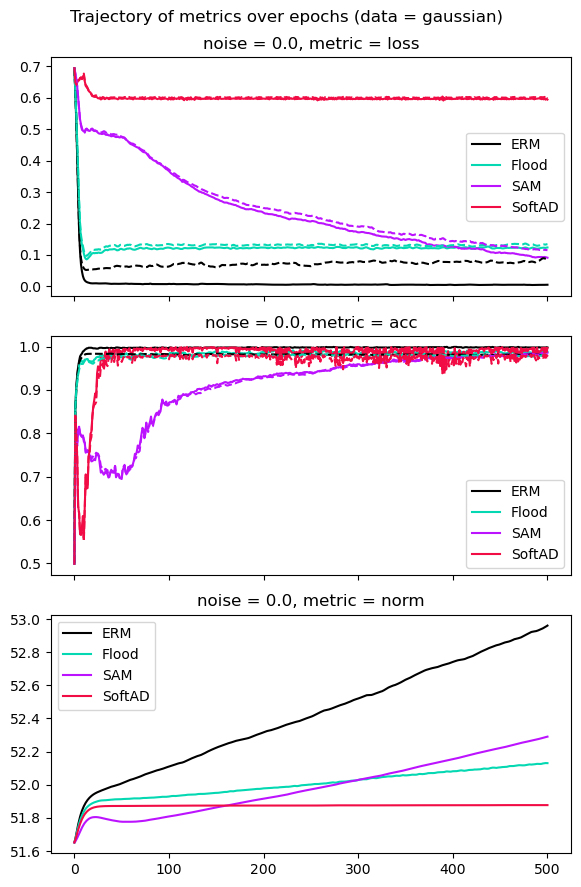

noise level: 0.05 (Ishida, params.flood_level)
mean: 0.2855384615384615 stdev: 0.08581674631207402
1651    0.46923076923076923
1667    0.41820512820512823
1684    0.36717948717948723
1694    0.36717948717948723
1706     0.3161538461538462
1710     0.2651282051282051
1715     0.2651282051282051
1718     0.2651282051282051
1719     0.2651282051282051
1723     0.2651282051282051
1728    0.21410256410256412
1731    0.21410256410256412
1735    0.21410256410256412
1737    0.21410256410256412
1747     0.1630769230769231
Name: params.flood_level, dtype: object
noise level: 0.05 (SAM, params.radius)
mean: 1.095145299145299 stdev: 0.31658619592199205
748      1.540769230769231
759     1.4897435897435898
792     1.3876923076923078
796     1.3366666666666667
810     1.2856410256410258
824     1.2856410256410258
833     1.2346153846153847
851     1.1835897435897436
862     1.1325641025641027
910     0.9794871794871796
948     0.8264102564102564
950     0.8264102564102564
979     0.7243589743589745


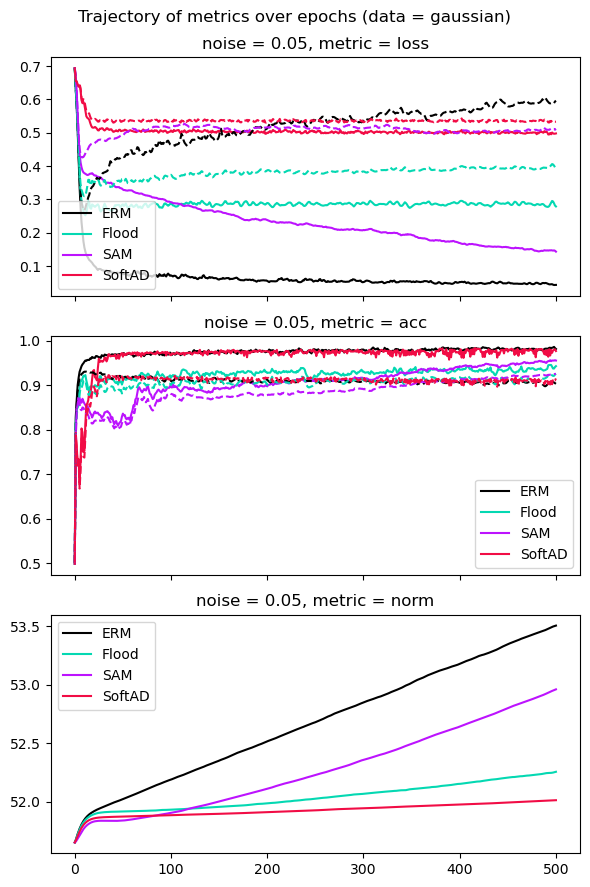

In [10]:
# List of metrics to use for each subplot.
metrics_to_use_list = [["loss_tr", "loss_te"], ["acc_tr", "acc_te"], ["model_norm"]]

# Color setup.
colors_by_method = {
    "ERM": "xkcd:black",
    "Ishida": "xkcd:aquamarine",
    "SAM": "xkcd:neon purple",
    "SoftAD": "xkcd:pinkish red"
}

# Name setup.
plotnames_by_method = {
    "ERM": "ERM",
    "Ishida": "Flood",
    "SAM": "SAM",
    "SoftAD": "SoftAD"
}

# Extra details to check.
extras_by_method = {
    "ERM": [],
    "Ishida": ["params.flood_level"],
    "SAM": ["params.radius"],
    "SoftAD": ["params.theta"],
}

# Set up main loop, again over all noise levels.
client = mlflow.tracking.MlflowClient()
for i, noise_level in enumerate(notnull_noise_levels):

    # Prepare the figure (one sub-plot per metric, but with tr and te on same plot).
    fig, axes = plt.subplots(3, figsize=(6, 3*len(metrics_to_use_list)), sharex=True)

    # Get the run IDs selected for all methods at this noise level.
    best_run_ids = dict_of_run_ids[noise_level]

    # For each method, look at extra info of interest.
    for mth_family_name in best_run_ids:
        extras_list = extras_by_method[mth_family_name]
        if len(extras_list) > 0:
            df = runs_notnull_parsed[runs_notnull_parsed["run_id"].isin(best_run_ids[mth_family_name])]
            for extra_name in extras_list:
                print("noise level:", noise_level, "({}, {})".format(mth_family_name, extra_name))
                print("mean:", df[extra_name].astype(float).mean(),
                      "stdev:", df[extra_name].astype(float).std())
                print(df[extra_name])

    # Get a loop going.
    for ax, metrics_to_use in zip(axes, metrics_to_use_list):

        # Process things for the first metric (always at least one).
        metric_to_use = metrics_to_use[0] # set metric name by hand.
        print("final values (ave, {})".format(metric_to_use))
        for mth_family_name in best_run_ids:
            # Get metrics for the representative candidates.
            metric_array = [
                [s.value for s in client.get_metric_history(r, metric_to_use)] for r in best_run_ids[mth_family_name]
            ]
            # Organize into a numpy array, and plot the average over trials.
            metric_array = np.array(metric_array)
            #print("DBDB", mth_family_name, metric_to_use, metric_array.shape)
            ax.plot(
                np.arange(0, metric_array.shape[1], 1), metric_array.mean(axis=0),
                color=colors_by_method[mth_family_name],
                linestyle="solid",
                label=plotnames_by_method[mth_family_name]
            )
            print(" ", metric_array.mean(axis=0)[-1], "({})".format(mth_family_name))

        # If have more than one metric, plot the second one, but no more.
        if len(metrics_to_use) > 1:
            metric_to_use = metrics_to_use[1] # set metric name by hand.
            print("final values (ave, {})".format(metric_to_use))
            for mth_family_name in best_run_ids:
                # Get metrics for the representative candidates.
                metric_array = [
                    [s.value for s in client.get_metric_history(r, metric_to_use)] for r in best_run_ids[mth_family_name]
                ]
                # Organize into a numpy array, and plot the average over trials.
                metric_array = np.array(metric_array)
                ax.plot(
                    np.arange(0, metric_array.shape[1], 1), metric_array.mean(axis=0),
                    color=colors_by_method[mth_family_name],
                    linestyle="dashed"
                )
                print(" ", metric_array.mean(axis=0)[-1], "({})".format(mth_family_name))
        if len(metrics_to_use) > 2:
            raise ValueError("Expected one or two metrics, no more/less.")

        # Having plotted for all methods, configure other parts of the current sub-plot.
        metric_name_for_plot = metrics_to_use[0].split("_")[0 if len(metrics_to_use) > 1 else 1]
        ax.set_title("noise = {}, metric = {}".format(noise_level, metric_name_for_plot))
        ax.legend(loc="best")
    
    # Finally, macroscropic settings for the whole figure.
    fig.suptitle(
        "Trajectory of metrics over epochs (data = {})".format(data_name)
    )
    plt.tight_layout()
    fname = os.path.join(img_path, "synthetic_{}_noise-{}.{}".format(data_name, i, my_ext))
    plt.savefig(fname=fname)
    plt.show()

___